In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
# progressbar
from progressbar import progressbar
# import test data
import pandas as pd
# for downloading pdb files
import urllib.request
import urllib.error
# import proaffinity inference module
from ProAffinity_GNN_inference import run_proaffinity_inference
# import ionerdss for surface contacting estimation
import sys 
sys.path.append( os.path.dirname( '/Users/msang/GitHub/ionerdss/ionerdss' ) )
import ionerdss as ion

In [2]:
def download_pdb_direct(pdb_id, download_dir="pdbfiles", verbose=False):
    """
    Direct download from RCSB PDB using urllib (alternative to Bio.PDB.PDBList)
    """
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    
    clean_id = pdb_id.strip().lower()
    
    # Different URL formats for different file types
    url = f"https://files.rcsb.org/download/{clean_id}.pdb"
    filename = f"{clean_id}.pdb"
    
    filepath = os.path.join(download_dir, filename)
    
    try:
        # check if the file already existed
        if os.path.exists(filepath):
            if verbose: print(f"Existed file: {clean_id.upper()} from {url}...")
            return filepath
        else:
            if verbose: print(f"Downloading {clean_id.upper()} from {url}...")
            urllib.request.urlretrieve(url, filepath)
            # Check if file was downloaded and has content
            if os.path.exists(filepath) and os.path.getsize(filepath) > 0:
                if verbose: print(f"✓ Successfully downloaded: {filepath}")
                return filepath
            else:
                print(f"✗ Download failed or file is empty: {clean_id.upper()}")
                return None
            
    except urllib.error.HTTPError as e:
        if e.code == 404:
            print(f"✗ File not found (404): {clean_id.upper()}")
        else:
            print(f"✗ HTTP Error {e.code}: {clean_id.upper()}")
        return None
    except Exception as e:
        print(f"✗ Error downloading {clean_id.upper()}: {str(e)}")
        return None

In [3]:
def convert_pka_dG(pka, temperature=298.15):
    K = 10**pka
    R = 8.314 / 1000 # kJ/(mol*K)
    dG = -R * temperature * np.log(K)
    return dG



def kbt_to_kj_mol(dG, T_kelvin=298.15):
    """
    Convert k_B T to kJ/mol
    
    Parameters:
    temperature_celsius (float): Temperature in Celsius (default: 25°C)
    
    Returns:
    float: k_B T value in kJ/mol
    """
    
    k_B = 1.380649e-23  # Boltzmann constant in J/K
    N_A = 6.02214076e23  # Avogadro's number in mol^-1
    R = k_B * N_A  # Gas constant R = k_B * N_A = 8.314 J/(mol·K)

    kbt_joules = k_B * T_kelvin  # k_B T in Joules per particle
    kbt_kj_mol = kbt_joules * N_A / 1000  # Convert to kJ/mol
    return kbt_kj_mol * np.array(dG)

In [7]:
# unit conversion, and shift in ionerdss
kbt_to_kj_mol(1), kbt_to_kj_mol(2.27)

(2.4789570296023884, 5.6272324571974215)

In [4]:
def ionerdss_prediction(pdbfile, pdbid, chains):
    # get the energy of interfaces from coarse graining
    model = ion.PDBModel(pdb_file=pdbfile, save_dir=f'ionerdss/{pdbid}')
    model.coarse_grain()
    energy_dict = {}
    for i, chain in enumerate(model.all_chains):
        for j, interface in enumerate(model.all_interfaces[i]):
            pairname = ','.join(sorted([chain.id, interface]))
            energy_dict.update({pairname: round(model.all_interface_energies[i][j], 5)})
    # parse chains (in the format of 'XY,AB'
    chain_group_1, chain_group_2 = chains.split(',')
    chain_pairs = []
    for chain_i in chain_group_1:
        for chain_j in chain_group_2:
            chain_pairs.append( ','.join(sorted([chain_i, chain_j])) )
    # calculate total energy
    dG_tot = 0
    for pair in chain_pairs:
        if pair in energy_dict:
            dG_tot += energy_dict[pair]
        else:
            pass # No interface found by ionerdss
    return dG_tot

In [5]:
test_set_1 = pd.read_excel('ci4c01850_si_003.xls')
test_set_2 = pd.read_excel('ci4c01850_si_004.xls')

In [6]:
def get_true_and_predictions(test_set, get_ionerdss=True, get_proaffinity=True):
    dG_proaffinity_test_set = []
    dG_ionerdss_test_set = []
    dG_true_test_set = []
    for row in test_set.itertuples():
        print(f'Processing {row.PDB.upper()} ...', end='\t')
        # get pdb file and parse data
        pdbfile = download_pdb_direct(row.PDB)
        chains = row._3.strip().rstrip(";").replace(';', ',')
        # ionerdss prediction
        if get_ionerdss:
            print('ionerdss ...', end='\t')
            dG_pred = ionerdss_prediction(pdbfile, row.PDB, chains)
            dG_ionerdss_test_set.append(dG_pred)
            dG_true_test_set.append(convert_pka_dG(row.pKa))
        else:
            pass
        # proaffinity predictions
        if get_proaffinity:
            print('proaffinity ...', end='\t')
            try:
                dG_pred = run_proaffinity_inference(pdbfile, chains)
                print(f"Successed! ")
            except Exception as e:
                dG_pred = np.nan
                print(f"Error!:\n", e)
            dG_proaffinity_test_set.append(dG_pred)
        else:
            print(f"Successed! ")
    return np.array(dG_proaffinity_test_set), 
        np.array(dG_ionerdss_test_set), 
        np.array(dG_true_test_set)

In [11]:
dG_proaffinity_test_set_1 , dG_ionerdss_test_set_1, dG_true_test_set_1 = get_true_and_predictions(test_set_1, get_proaffinity=True)
# dG_proaffinity_test_set_2 , dG_ionerdss_test_set_2, dG_true_test_set_2 = get_true_and_predictions(test_set_2, get_proaffinity=False)

Processing 1WEJ ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1PPE ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1PVH ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 3SGB ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1KTZ ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2PCC ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2MTA ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1FSK ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1R0R ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2PCB ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1P2C ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1JTG ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1BJ1 ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1JPS ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1Z0K ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2TGP ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1MLC ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2GOX ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1J2J ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2AJF ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1ZHI ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1E96 ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1KXQ ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1AVZ ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1QA9 ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1CBW ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1BUH ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1DQJ ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1EWY ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2VIR ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2VIS ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2A9K ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2OOB ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1BVN ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1EFN ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2ABZ ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1GCQ ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1HE8 ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1KAC ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1GLA ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1S1Q ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1VFB ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2FJU ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1E6J ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1US7 ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1ACB ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 3BZD ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1A2K ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1AKJ ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2HQS ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1K5D ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1EZU ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2I25 ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1BVK ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1JWH ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1EMV ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1XU1 ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1AK4 ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1E6E ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1GXD ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1I4D ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Error!:
 Encountered an index error. Please ensure that all indices in 'edge_index' point to valid indices in the interval [0, 369] (got interval [0, 372])
Processing 1FFW ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 4CPA ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2WPT ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1FC2 ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1MQ8 ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1XQS ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1LFD ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2AQ3 ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1B6C ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2HRK ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2NYZ ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1I2M ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 3CPH ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1KKL ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1EER ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1E4K ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 2C0L ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 
Processing 1ATN ...	ionerdss ...	proaffinity ...	

/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Successed! 


In [15]:
from scipy.stats import pearsonr

# Calculate correlation and significance
print('ionerdss:')
correlation, p_value = pearsonr(dG_true_test_set_1, kbt_to_kj_mol(dG_ionerdss_test_set_1))
print(f"Correlation: {correlation**2:.3f}")
print(f"P-value: {p_value:.3f}")

print('ProAffinity:')
dG_true_test_set_1 = np.array(dG_true_test_set_1)
dG_proaffinity_test_set_1 = np.array(dG_proaffinity_test_set_1)
nans = np.isnan(dG_proaffinity_test_set_1)
correlation, p_value = pearsonr(dG_true_test_set_1[~nans], dG_proaffinity_test_set_1[~nans])
print(f"Correlation: {correlation**2:.3f}")
print(f"P-value: {p_value:.3f}")

ionerdss:
Correlation: 0.098
P-value: 0.005
ProAffinity:
Correlation: 0.233
P-value: 0.000


Text(0, 0.5, 'Predicted dG (kJ/mol)')

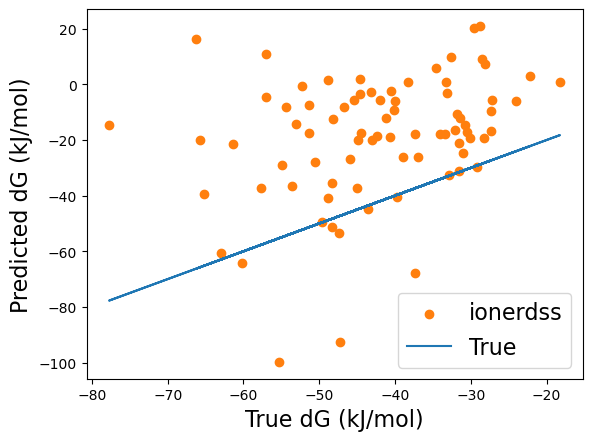

In [20]:
plt.scatter(dG_true_test_set_1, kbt_to_kj_mol(dG_ionerdss_test_set_1), color='tab:orange', label='ionerdss')
# plt.scatter(dG_true_test_set_2, kbt_to_kj_mol(dG_ionerdss_test_set_2), color='tab:orange')
plt.plot(dG_true_test_set_1, dG_true_test_set_1, label='True')
plt.legend(fontsize=16)
plt.xlabel('True dG (kJ/mol)', fontsize=16)
plt.ylabel('Predicted dG (kJ/mol)', fontsize=16)

In [97]:
len(dG_proaffinity_test_set_1), len(dG_true_test_set_1)

(79, 79)

Text(0, 0.5, 'Predicted dG (kJ/mol)')

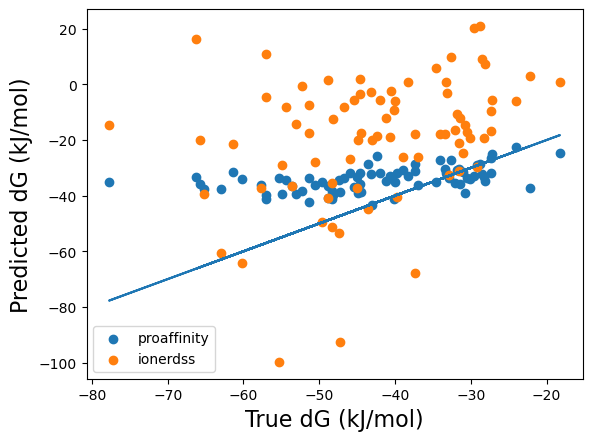

In [98]:
plt.scatter(dG_true_test_set_1, dG_proaffinity_test_set_1, label='proaffinity')
plt.scatter(dG_true_test_set_1, kbt_to_kj_mol(dG_ionerdss_test_set_1), label='ionerdss')
plt.plot(dG_true_test_set_1, dG_true_test_set_1)
plt.legend()
plt.xlabel('True dG (kJ/mol)', fontsize=16)
plt.ylabel('Predicted dG (kJ/mol)', fontsize=16)

In [ ]:
len(dG_proaffinity_test_set_2), len(dG_true_test_set_2)

Text(0, 0.5, 'Predicted dG (kJ/mol)')

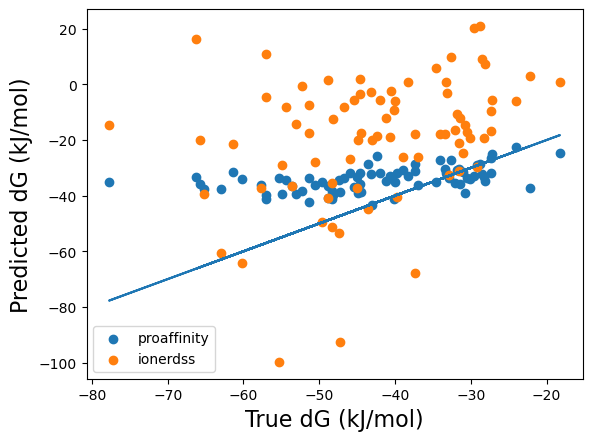

In [98]:
plt.scatter(dG_true_test_set_2, dG_proaffinity_test_set_2, label='proaffinity')
plt.scatter(dG_true_test_set_2, kbt_to_kj_mol(dG_ionerdss_test_set_2), label='ionerdss')
plt.plot(dG_true_test_set_2, dG_true_test_set_2)
plt.legend()
plt.xlabel('True dG (kJ/mol)', fontsize=16)
plt.ylabel('Predicted dG (kJ/mol)', fontsize=16)

In [7]:
def _get_default_energy_table():
    """Returns energy table for residue-residue interactions.

    Reference:
        Miyazawa, S., & Jernigan, R. L. (1996). Residue-residue potentials 
        with a favorable contact pair term and an unfavorable high packing density term,
        for simulation and threading. J Mol Biol, 256(3), 623–644.

    Returns:
        dict: A symmetric dictionary with residue pair tuples as keys and contact energies (in RT units) as values.
    """
    residues = [
        'CYS', 'MET', 'PHE', 'ILE', 'LEU', 'VAL', 'TRP', 'TYR', 'ALA', 'GLY',
        'THR', 'SER', 'ASN', 'GLN', 'ASP', 'GLU', 'HIS', 'ARG', 'LYS', 'PRO'
    ]

    # Extracted from the upper triangle of the table (manually transcribed)
    energy_matrix = [
        [-5.44],
        [-4.99, -5.46],
        [-5.80, -6.56, -7.26],
        [-5.50, -6.02, -6.84, -6.54],
        [-5.83, -6.41, -7.28, -7.04, -7.37],
        [-4.96, -5.32, -6.29, -6.05, -6.48, -5.52],
        [-4.95, -5.55, -6.16, -5.78, -6.14, -5.18, -5.06],
        [-4.16, -4.91, -5.66, -5.25, -5.67, -4.62, -4.66, -4.17],
        [-3.57, -3.94, -4.81, -4.58, -4.91, -4.04, -3.82, -3.36, -2.72],
        [-3.16, -3.39, -4.13, -3.78, -4.16, -3.38, -3.42, -3.01, -2.31, -2.24],
        [-3.11, -3.51, -4.28, -4.03, -4.34, -3.46, -3.22, -3.01, -2.32, -2.08, -2.12],
        [-2.86, -3.03, -4.02, -3.52, -3.92, -3.05, -2.99, -2.78, -2.01, -1.82, -1.96, -1.67],
        [-2.59, -2.95, -3.75, -3.24, -3.74, -2.83, -3.07, -2.76, -1.84, -1.74, -1.88, -1.58, -1.68],
        [-2.85, -3.30, -4.10, -3.67, -4.04, -3.07, -3.11, -2.97, -1.89, -1.66, -1.90, -1.49, -1.71, -1.54],
        [-2.41, -2.57, -3.48, -3.17, -3.40, -2.48, -2.84, -2.76, -1.70, -1.59, -1.80, -1.63, -1.68, -1.46, -1.21],
        [-2.27, -2.89, -3.56, -3.27, -3.59, -2.67, -2.99, -2.79, -1.51, -1.22, -1.74, -1.48, -1.51, -1.42, -1.02, -0.91],
        [-3.60, -3.98, -4.77, -4.14, -4.54, -3.58, -3.98, -3.52, -2.41, -2.15, -2.42, -2.11, -2.08, -1.98, -2.32, -2.15, -3.05],
        [-2.57, -3.12, -3.98, -3.63, -4.03, -3.07, -3.41, -3.16, -1.83, -1.72, -1.90, -1.62, -1.64, -1.80, -2.29, -2.27, -2.16, -1.55],
        [-1.95, -2.48, -3.36, -3.01, -3.37, -2.49, -2.69, -2.60, -1.31, -1.15, -1.31, -1.05, -1.21, -1.29, -1.68, -1.80, -1.35, -0.59, -0.12],
        [-3.07, -3.45, -4.25, -3.76, -4.20, -3.32, -3.73, -3.19, -2.03, -1.87, -1.90, -1.57, -1.53, -1.73, -1.33, -1.26, -2.25, -1.70, -0.97, -1.75]
    ]

    energy_table = {}

    for i, res_i in enumerate(residues):
        for j, res_j in enumerate(residues[:i+1]):
            energy = energy_matrix[i][j] + 2.27  # Adjusted energy value
            energy_table[(res_i, res_j)] = energy
            energy_table[(res_j, res_i)] = energy  # symmetry

    return energy_table

energy_table = _get_default_energy_table()


def convert_residue_codes(one_letter_tuple):
    """
    Convert a tuple of one-letter amino acid codes to three-letter codes.
    
    Args:
        one_letter_tuple: Tuple of one-letter amino acid codes (e.g., ('Q', 'E'))
    
    Returns:
        Tuple of three-letter amino acid codes (e.g., ('Gln', 'Glu'))
    """
    
    # Mapping dictionary from one-letter to three-letter codes
    aa_mapping = {
        'A': 'Ala',  # Alanine
        'C': 'Cys',  # Cysteine
        'D': 'Asp',  # Aspartic acid
        'E': 'Glu',  # Glutamic acid
        'F': 'Phe',  # Phenylalanine
        'G': 'Gly',  # Glycine
        'H': 'His',  # Histidine
        'I': 'Ile',  # Isoleucine
        'K': 'Lys',  # Lysine
        'L': 'Leu',  # Leucine
        'M': 'Met',  # Methionine
        'N': 'Asn',  # Asparagine
        'P': 'Pro',  # Proline
        'Q': 'Gln',  # Glutamine
        'R': 'Arg',  # Arginine
        'S': 'Ser',  # Serine
        'T': 'Thr',  # Threonine
        'V': 'Val',  # Valine
        'W': 'Trp',  # Tryptophan
        'Y': 'Tyr',  # Tyrosine
    }
    
    # Convert each one-letter code to three-letter code
    try:
        three_letter_codes = tuple(aa_mapping[code.upper()].upper() for code in one_letter_tuple)
        print('-'.join(three_letter_codes))
        return three_letter_codes
    except KeyError as e:
        raise ValueError(f"Invalid amino acid code: {e}")

In [9]:
pdbid = '8y7s'
print(f'Processing {pdbid.upper()} ...', end='\t')
# get pdb file and parse data
pdbfile = download_pdb_direct(pdbid)
chains = 'A,F'
# ionerdss prediction
print('ionerdss ...', end='\t')
dG_pred = ionerdss_prediction(pdbfile, pdbid, chains)
print('dG = %.4f KJ/mol'%kbt_to_kj_mol(dG_pred))

Processing 8Y7S ...	ionerdss ...	dG = 0.0496 KJ/mol
